In [1]:
from scipy import *
from numpy import *
from scipy.interpolate import interp1d
from scipy import optimize, stats
from matplotlib import pyplot as plt
import os,sys

import PR_dataset
print('Using PR_dataset.py v%s'%PR_dataset.__version__)

Using PR_dataset.py v1.5


In [2]:
################################
########## PARAMETERS ##########

##------ General -------##

# Prefactor of the MSD (in µm^2/s^0.5)
G = 0.001627 # Measured on 5-sec resolution traces taken before (n=11) and after (n=8) the 30'-PR experiments of 20210723

kT = 1.3806e-23 * 310. /1e-12/1e-6 # in pN.µm


##------ 30min-pull/release data -------##

dataPath_30min = '../data/2-trajectory_files/30min-PR'
fnames_30min = ['20190410_Pos20_cell0_.txt', '20190415_Pos1_cell0_.txt', '20191217_Pos15_cell0_.txt', '20191217_Pos22_cell3_.txt', '20191223_Pos0_cell0_.txt', '20191223_Pos2_cell0_.txt', '20191223_Pos11_cell0_.txt', '20200221_Pos4_cell0_.txt', 
          '20191217_Pos22_cell0.txt', '20191217_Pos25_cell0.txt', '20191223_Pos10_cell0.txt', '20191223_Pos11_cell1.txt', '20200221_Pos5_cell0.txt', '20210719_Pos2_cell0.txt', '20210719_Pos3_cell1.txt', '20210719_Pos6_cell0.txt', '20210721_Pos4_cell0.txt', '20210721_Pos5_cell1.txt', '20210721_Pos6_cell1.txt', '20210721_Pos6_cell2.txt', '20210721_Pos7_cell0.txt', '20210721_Pos7_cell2.txt', '20210721_Pos9_cell0.txt', '20210723_Pos0_cell0.txt', '20210723_Pos0_cell2.txt', '20210723_Pos0_cell3.txt', '20210723_Pos0_cell4.txt', '20210723_Pos1_cell0.txt', '20210723_Pos1_cell2.txt', '20210723_Pos3_cell0.txt', '20210723_Pos3_cell1.txt', '20210723_Pos3_cell2.txt', '20210723_Pos4_cell0.txt', '20210723_Pos4_cell1.txt', '20210723_Pos8_cell0.txt']
release_times_30min = 60*r_[53.37, 60.48, 33.18, 33.18, 30.00, 30.00, 30.00, 30.10,
                            33.18, 33.18, 30.00, 30.00, 30.10, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, 30.00, ] # (in s) From labjournals and image timestamps

##------ 10x 100sec-pull/release data -------##

dataPath_100s='../data/2-trajectory_files/100s-PR/'
fnTracking_100s="20200304_100s-PR_trajectory.trk2"
fnFxyz_100s="20200304_100s-PR_Fxyz.csv"

pixelSize=0.129 # um
dt=5 # sec
delaySwitchMagnet=dt-1 # Delay in sec between placement/removal of magnet and acquisition of image

##------ dt=0.5sec pull/release data -------##

dataPath_05s = '../data/2-trajectory_files//dt-0.5s'
fnames_05s = ['20210722_dt-0.5s_Pos0_cell0_ref-cell2.txt', '20210722_dt-0.5s_Pos0_cell1_ref-cell2.txt', '20210722_dt-0.5s_Pos9_cell0_ref-cells1-3.txt', ]
pull_t0_frames = [[34,35], [34,35], [19,20]]
release_t0_frames = [[186,187], [186,187], [99]]


##------ Display -------##

colors={'force':          '#f07100',
        'diffusion_fill': '#efefef',
        'diffusion_hatch':'#c8c8c8',
        'theory':         '#b0000f'}

cm_traj_30min=plt.cm.colors.LinearSegmentedColormap('cm_traj_30min',
    {'red':   ((0,.2,.2),(.6,.4,.4),(.85,.5 ,.5 ),(1,.3,.3)),
     'green': ((0,.8,.8),(.6,.3,.3),(.85,.3 ,.3 ),(1,.3,.3)),
     'blue':  ((0,.8,.8),(.6,.8,.8),(.85,.65,.65),(1,.3,.3))})

cm_traj_100s=plt.cm.colors.LinearSegmentedColormap('cm_traj_100s',
    {'red':   ((0,.0,.0),(.5,.3,.3),(1,.6,.6)),
     'green': ((0,.3,.3),(.5,.6,.6),(1,.6,.6)),
     'blue':  ((0,.2,.2),(.5,.0,.0),(1,.1,.1))})

cm_traj_dt05s=plt.cm.colors.LinearSegmentedColormap('cm_traj_dt05s',
    {'red':   ((0,.6,.6),(1,.8,.8)),
     'green': ((0,.6,.6),(1,.4,.4)),
     'blue':  ((0,.6,.6),(1,.2,.2))})

################################
################################

if 0:
    plt.figure()
    for i in range(35): plt.plot(r_[0,1], r_[0,0]+i/35., c=cm_traj_30min(i/35.))
    plt.savefig('key_30min_colorcode.pdf')


In [3]:
##------ Load 30min-pull/release data -------##

fnamesPath_30min = [os.path.join(dataPath_30min, fname) for fname in fnames_30min]
data_30min = [PR_dataset.dataset(os.path.join(dataPath_30min, fname), tRelease=tR,
                                 fnameDistNE=os.path.join(dataPath_30min,'distNE/', fname[:-4]+'_distNE.txt'))
              for fname, tR in zip(fnames_30min, release_times_30min)]

##------ Load 10x 100sec-pull/release data -------##

dataTracking=loadtxt(dataPath_100s+fnTracking_100s)
# 0:frame  1:X  2:Y  3:Z   4:fluo  5:bg  6:bgTiltX  7:bgTiltY  8:bgTiltZ  9(bits: spot detected, fit convereged)

Fxyz=loadtxt(dataPath_100s+fnFxyz_100s,skiprows=1,delimiter=';')[:,1:] * r_[1,-1,-1] # in pN

# Time
t=dataTracking[:,0]*dt+delaySwitchMagnet

# Position
pos=dataTracking[:,1:3]*pixelSize * r_[1,-1]
pos-=pos[:20].mean(0) # Center on origin

# Frame index of each pull and each release
indPull   =where(diff((Fxyz[:,0]!=0)*1)==1)[0]+1
indRelease=where(diff((Fxyz[:,0]!=0)*1)==-1)[0]+1
tPull=indPull*dt; tRelease=indRelease*dt; 

##------ Load dt=0.5sec pull/release data -------##

fnames_05s = [os.path.join(dataPath_05s, fname) for fname in fnames_05s]
data_05s = [PR_dataset.dataset(fname, tPull=fP, tRelease=fR, nbFramesForBaseline_pull=10, nbFramesForBaseline_release=5)
              for fname, fP, fR in zip(fnames_05s, pull_t0_frames, release_t0_frames)]



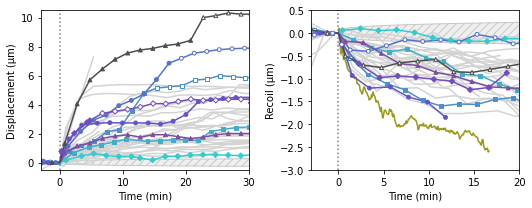

In [4]:
fig,ax=plt.subplots(1,2,figsize=[7.5,3])

envelope100s=(lambda tt: c_[interp1d(t[indPull-1]-t[indPull[0]-1],pos[indPull-1,1],bounds_error=False)(tt),
                           interp1d(t[r_[0,indRelease-1]]-t[indPull[0]-1],pos[r_[0,indRelease-1],1],bounds_error=False)(tt)])
force100s_avgOverPRcycles=interp1d(
    array([[t[indPull[i]],t[indPull[i+1]-1]]              for i in r_[:indPull.shape[0]-1]]).reshape(-1),
    array([Fxyz[indPull[i]:indPull[i+1],1].mean()*r_[1,1] for i in r_[:indPull.shape[0]-1]]).reshape(-1),    
    bounds_error=False,fill_value=0)


##------ 30min-pull/release data -------##

#rankByInitForce=argsort(argsort([ds.F[ds.indON,1] for ds in data_30min]))/(len(data_30min)-1) # Ranks for initial force at start of pull
rankByInitForce=r_[19, 34,  1, 10, 20,  0, 23,  9, 26,  5,  8, 17, 14, 24, 28, 33, 22, 12, 16, 18, 31, 15, 11,  3,  4, 32,  7, 27, 21, 29,  6, 13,  2, 30, 25]/(len(data_30min)-1) # Ranks for initial force calculate over Delta_t=5min

tracesToHighlight=[2,4,7,9,11,14,21,29,] # Chosen to represent the diversity of behavior: from weak to large forces, including large displacement despite weak force and moderate displacement despite large force, and including trajectories with and without heterogeneities / change of regime.
rankByInitForceForTracesToHighlight=argsort(argsort([rankByInitForce[i] if i in tracesToHighlight else 1000 for i in range(len(rankByInitForce))]))/(len(tracesToHighlight)-1)

plt.sca(ax[0]); ii=0
for i,ds in enumerate(data_30min):
    if i not in tracesToHighlight:
        plt.plot   (ds.t/60,   ds.x[:,1],   c='lightgray', zorder=0)
    else:
        col=cm_traj_30min(rankByInitForceForTracesToHighlight[i])
        plt.plot   (ds.t/60,   ds.x[:,1],   c=   col,  zorder=rankByInitForce[i])#, ls=['--',':','-'][(ii//3)%3])
        plt.scatter(ds.t_m/60, ds.x_m[:,1], ec=c_[col], zorder=rankByInitForce[i]+.5, s=15, marker='DDsso^o^'[ii], fc=array([[r_[1,1,1,1],col][a] for a in (ds._data[:,-2]> 1.5 )*1]))
        ii+=1
# 100s PR trace
#plt.fill_between((t-t[indPull[0]-1])/60,envelope100s(t-t[indPull[0]-1])[:,0],
#                                        envelope100s(t-t[indPull[0]-1])[:,1],edgecolor=cm_traj_100s(.4)[:3]+(.4,),
#                                                                             facecolor=cm_traj_100s(.4)[:3]+(.05,),zorder=0)
# Diffusion background
plt.fill_between((t-t[0])/60,-(G*(t-t[0])**.5)**.5,(G*(t-t[0])**.5)**.5,edgecolor=colors['diffusion_hatch'],facecolor=colors['diffusion_fill'],hatch='///',zorder=0)
plt.axvline(0,c='gray',ls=':',zorder=0); #plt.axhline(0,c='gray',ls=':',zorder=0);
plt.xlabel("Time (min)"); plt.ylabel("Displacement (µm)")
plt.xlim(-3,30); plt.ylim(-0.5,10.5)

plt.sca(ax[1]); ii=0
for i,ds in enumerate(data_30min):
    if not hasattr(ds,'indOFF'): continue
    if i not in tracesToHighlight:
        plt.plot   ((ds.t  -ds.t[ds.indOFF])/60, ds.x[:,1]  -ds.x[ds.indOFF,1],   c='lightgray', zorder=0)
    else:
        col=cm_traj_30min(rankByInitForceForTracesToHighlight[i])
        plt.plot   ((ds.t  -ds.t[ds.indOFF])/60, ds.x[:,1]  -ds.x[ds.indOFF,1], c=   col,   zorder=rankByInitForce[i])#, ls=['--',':','-'][(ii//3)%3])
        plt.scatter((ds.t_m-ds.t[ds.indOFF])/60, ds.x_m[:,1]-ds.x[ds.indOFF,1], ec=c_[col], zorder=rankByInitForce[i]+.5, s=15, marker='DDsso^o^'[ii], fc=array([[r_[1,1,1,1],col][a] for a in (ds._data[:,-2]> 1.5 )*1]))
        ii+=1
# Last pull from 100s PR data:
plt.plot((t[:t.shape[0]-indRelease[-1]+1]-dt)/60,pos[indRelease[-1]-1:,1]-pos[indRelease[-1]-1,1],c=cm_traj_100s(1.),zorder=0)
# Diffusion background
plt.fill_between((t-t[0])/60,-(G*(t-t[0])**.5)**.5,(G*(t-t[0])**.5)**.5,edgecolor=colors['diffusion_hatch'],facecolor=colors['diffusion_fill'],hatch='///',zorder=0)
plt.axvline(0,c='gray',ls=':',zorder=0); #plt.axhline(0,c='gray',ls=':',zorder=0);
plt.xlabel("Time (min)"); plt.ylabel("Recoil (µm)")
plt.xlim(-3,20); plt.ylim(-3.,0.5)


plt.tight_layout()
plt.savefig('fig2_allPRs.pdf')



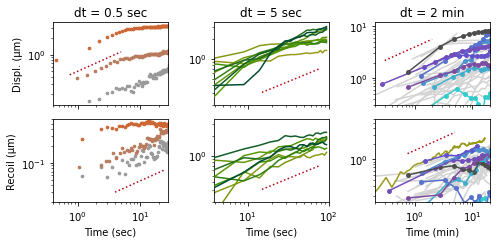

In [5]:
fig,ax=plt.subplots(2,3,sharex='col',sharey=False,figsize=[7,3.5])

##------ dt=0.5sec pull/release data -------##

plt.sca(ax[0,0]); plt.title('dt = 0.5 sec')
for i,ds in enumerate(data_05s):
    plt.scatter(ds.t_m, ds.x_m[:,1], s=7, c=c_[cm_traj_dt05s([1.,0.,.6][i])])

plt.ylabel("Displ. (µm)")
plt.xlim(.4,28); plt.ylim(.125,3.75); plt.xscale('log'); plt.yscale('log');
slopeline=r_[.75,5]; plt.plot(slopeline,.5*slopeline**.5, c=colors['theory'], ls=':')

plt.sca(ax[1,0])
for i,ds in enumerate(data_05s):
    if not hasattr(ds,'indOFF'): continue
    plt.scatter((ds.t_m-ds.t[ds.indOFF]), -(ds.x_m[:,1]-ds.x[ds.indOFF,1]), s=7, c=c_[cm_traj_dt05s([1.,0.,.6][i])])
plt.xlabel("Time (sec)"); plt.ylabel("Recoil (µm)")
plt.xlim(.4,28); plt.ylim(.02,.6); plt.xscale('log'); plt.yscale('log');
slopeline=r_[4.,25]; plt.plot(slopeline,.015*slopeline**.5, c=colors['theory'], ls=':')


##------ 10x 100sec-pull/release data -------##

allPulls   =array([pos[i-1:][:20] for i in indPull   ]);
allReleases=array([pos[i-1:][:20] for i in indRelease]);
allPulls   =(allPulls.swapaxes(0,1)   -allPulls   [:,0]).swapaxes(0,1)
allReleases=(allReleases.swapaxes(0,1)-allReleases[:,0]).swapaxes(0,1)

plt.sca(ax[0,1]); plt.title('dt = 5 sec')
for i,currP in enumerate(allPulls):
    plt.plot(t[:currP.shape[0]]-dt,currP[:,1],label='P%d'%(i+1),c=cm_traj_100s(i/9),zorder=10-i)
plt.axvline(0,c='lightgray',zorder=0) ;plt.axhline(0,c='lightgray',zorder=0)
#plt.ylabel("Displ. (µm)");
plt.xscale('log'); plt.xlim(3.8,100); plt.yscale('log'); plt.ylim(.2,3.5);
slopeline=r_[15,75]; plt.plot(slopeline,.08*slopeline**.5, c=colors['theory'], ls=':')

plt.sca(ax[1,1])
for i,currR in enumerate(allReleases[:-1]):
    plt.plot(t[:currR.shape[0]]-dt,-currR[:,1],label='R%d'%(i+1),c=cm_traj_100s(i/9),zorder=10-i)
plt.axvline(0,c='lightgray',zorder=0) ;plt.axhline(0,c='lightgray',zorder=0)
plt.xlabel("Time (sec)"); #plt.ylabel("Recoil (µm)");
plt.xscale('log'); plt.xlim(3.8,100); plt.yscale('log'); plt.ylim(.2,3.5);
slopeline=r_[15,75]; plt.plot(slopeline,.08*slopeline**.5, c=colors['theory'], ls=':')


##------ 30min-pull/release data -------##

plt.sca(ax[0,2]); plt.title('dt = 2 min')
for i,ds in enumerate(data_30min):
    if i not in tracesToHighlight:
        plt.plot   (ds.t[ds.indON+1:]/60,   ds.x[ds.indON+1:,1],   c='lightgray', zorder=0)
    else:
        plt.plot   (ds.t[ds.indON+1:]/60,   ds.x[ds.indON+1:,1],   c=   cm_traj_30min(rankByInitForceForTracesToHighlight[i]),  zorder=rankByInitForce[i])
        plt.scatter(ds.t_m[ds.indON_m:]/60, ds.x_m[ds.indON_m:,1], c=c_[cm_traj_30min(rankByInitForceForTracesToHighlight[i])], zorder=rankByInitForce[i], s=15)
plt.axvline(0,c='lightgray',zorder=0); plt.axhline(0,c='lightgray',zorder=0)
#plt.ylabel("Displ. (µm)")
plt.xscale('log'); plt.xlim(.2,20); plt.yscale('log'); plt.ylim(.3,12);
slopeline=r_[.3,2]; plt.plot(slopeline,4*slopeline**.5, c=colors['theory'], ls=':')

plt.sca(ax[1,2])
for i,ds in enumerate(data_30min):
    if not hasattr(ds,'indOFF'): continue
    if i not in tracesToHighlight:
        plt.plot   ((ds.t[ds.indOFF+1:]  -ds.t[ds.indOFF])/60, -(ds.x[ds.indOFF+1:,1]  -ds.x[ds.indOFF,1]),   c='lightgray', zorder=0)
    else:
        plt.plot   ((ds.t[ds.indOFF+1:]  -ds.t[ds.indOFF])/60, -(ds.x[ds.indOFF+1:,1]  -ds.x[ds.indOFF,1]), c=   cm_traj_30min(rankByInitForceForTracesToHighlight[i]))
        plt.scatter((ds.t_m[ds.indOFF_m:]-ds.t[ds.indOFF])/60, -(ds.x_m[ds.indOFF_m:,1]-ds.x[ds.indOFF,1]), c=c_[cm_traj_30min(rankByInitForceForTracesToHighlight[i])], s=15)
# Last pull from 100s PR data:
plt.plot((t[:t.shape[0]-indRelease[-1]+1]-dt)/60,-(pos[indRelease[-1]-1:,1]-pos[indRelease[-1]-1,1]),c=cm_traj_100s(1.),zorder=0)
plt.axvline(0,c='lightgray',zorder=0) ;plt.axhline(0,c='lightgray',zorder=0)
plt.xlabel("Time (min)"); #plt.ylabel("Recoil (µm)")
plt.xscale('log'); plt.xlim(.2,20); plt.yscale('log'); plt.ylim(.15,6);
slopeline=r_[.75,5]; plt.plot(slopeline,1.5*slopeline**.5, c=colors['theory'], ls=':')


plt.tight_layout(); plt.savefig('fig2_allPRs_log.pdf')


Pulls: using 80.0% of traces (28/35)
Releases: using 60.0% of traces (21/35)


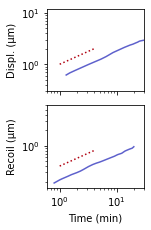

In [6]:
fig,ax=plt.subplots(2,1,figsize=(2.2,3.3),sharex=True,gridspec_kw={'height_ratios':[3,3]})

#----- Pulls -------
tavg=r_[1.3:30:.1]*60;
F_max=2. # pN
#-------------------

# Selection of traces that where F remains smaller than `F_max` pN
sel=[i for i,ds in enumerate(data_30min)
                       if ds.t[-1]>tavg[-1]
                          and (interp1d(ds.t,ds.F[:,1])(tavg)).max()<F_max]
print('Pulls: using %.1f%% of traces (%d/%d)'%(100*len(sel)/len(data_30min),len(sel),len(data_30min)))

# Interpolate and average
xavg,Favg=array([ [interp1d(ds.t,ds.x.T)(tavg).T,
                   interp1d(ds.t,ds.F.T)(tavg).T]
                       for i,ds in enumerate(data_30min) if i in sel]).mean(0)

plt.sca(ax[0])
plt.plot(tavg/60,xavg[:,1], c=cm_traj_30min(.5))
plt.plot(r_[1,4], r_[1,4]**.5, c=colors['theory'], ls=':', zorder=0)
plt.axhline(0,c='lightgray',zorder=0); plt.axvline(0,c='lightgray',zorder=0)
plt.xscale('log'); plt.yscale('log'); plt.ylim(.3,12);
plt.ylabel('Displ. (µm)');


#---- Releases -----
tavg=r_[.8:20:.1]*60;
max_disp_during_pull=5. # um
#-------------------

# Selection of traces that where the displacement during the pull is less than `max_disp_during_pull`
sel=[i for i,ds in enumerate(data_30min)
                       if hasattr(ds,'tRelease')
                          and ds.t[-1]-ds.tRelease>tavg[-1]
                          and ds.x[ds.indOFF,1]<max_disp_during_pull]
print('Releases: using %.1f%% of traces (%d/%d)'%(100*len(sel)/len(data_30min),len(sel),len(data_30min)))

# Interpolate and average
xavg=array([ (interp1d(ds.t-ds.tRelease,ds.x.T)(tavg).T-ds.x[ds.indOFF])
                       for i,ds in enumerate(data_30min) if i in sel]).mean(0)

plt.sca(ax[1])
plt.plot(tavg/60,-xavg[:,1], c=cm_traj_30min(.5))
plt.plot(r_[1,4], .4*r_[1,4]**.5, c=colors['theory'], ls=':', zorder=0)
plt.axhline(0,c='lightgray',zorder=0); plt.axvline(0,c='lightgray',zorder=0)
plt.xscale('log'); plt.xlim(.6,30); plt.yscale('log'); plt.ylim(.15,6);
plt.ylabel('Recoil (µm)');
plt.xlabel('Time (min)');

plt.tight_layout(); plt.savefig('fig2_avg_PRs_log.pdf')


Slope pull: 0.158±0.014 µm/s^0.5/pN
expected: 0.190 µm/s^0.5/pN
Slope release: -0.158±0.016
Pulls:    Pearson r = 0.732 (p-val = 2.570e-07)
Releases: Pearson r = -0.551 (p-val = 1.071e-03)


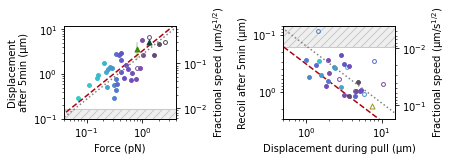

In [7]:
fig,ax=plt.subplots(1,2,figsize=[6.4,2.1])

Delta_t_P=5 # (min)
plt.sca(ax[0])
ptsForFit_P=[]

##------ 30min-pull/release data -------##
for i,ds in enumerate(data_30min):
    displacement=interp1d(ds.t,ds.x[:,1])(Delta_t_P*60)
    col=cm_traj_30min(rankByInitForce[i])

    #force=ds.F[ds.indON,1] # Initial force
    # Average force over Delta_t_P
    ind_Delta_t_P=where(ds.t > Delta_t_P*60)[0][0]
    temp_t=r_[ds.t[ds.indON:ind_Delta_t_P],Delta_t_P*60]
    temp_F=interp1d(ds.t,ds.F[:,1])(temp_t)
    force=sum((temp_F[:-1]+temp_F[1:])/2*diff(temp_t))/(temp_t[-1]-temp_t[0])    
    toAppend=[force, displacement, c_[col]]
    toAppend.append(ds._data[ds.indON_m-1][-2:]) # distNE before pull
    toAppend.append(interp1d(ds.t_m,ds._data[:,-2:].T)(Delta_t_P*60)) # Dist NE at Delta_t_P
    ptsForFit_P.append(toAppend)
    plt.scatter(force, displacement, ec=c_[col], fc=(toAppend[4][0]> 1.5 )*c_[col], zorder=rankByInitForce[i], s=15)

##------ 100s-pull/release data -------##
#---- From envelope of 100s PR trace
displacement=envelope100s(Delta_t_P*60)[0]

#force=Fxyz[indPull[0],1]/2 # Initial force
force=force100s_avgOverPRcycles(t[(t[indPull[0]]<=t)*(t<(t[indPull[0]]+Delta_t_P*60))]).mean() # Average force over Delta_t_P

plt.plot(   r_[1,1]*force, displacement,        c=   cm_traj_100s(.4), alpha=.3)
plt.scatter(        force, displacement.mean(), c=c_[cm_traj_100s(.4)], s=25, marker='^')
ptsForFit_P.append([force, displacement.mean(),   c_[cm_traj_100s(.4)]])

# Extrapolation from last point of first pull of 100s PR trace, assuming 0.5 power law
displacement=allPulls[0][-1,1]*(Delta_t_P*60/(t[allPulls[0].shape[0]]-dt))**.5
force=Fxyz[indPull[0]:indRelease[0],1].mean()
plt.scatter(force, displacement, c=c_[cm_traj_100s(0)], s=25, marker='^')
ptsForFit_P.append([force, displacement, c_[cm_traj_100s(0)]])

# Diffusion background
plt.fill_between(r_[1e-3,1e3],-(G*(Delta_t_P*60)**.5)**.5,(G*(Delta_t_P*60)**.5)**.5,edgecolor=colors['diffusion_hatch'],facecolor=colors['diffusion_fill'],hatch='///',zorder=0)

# Linear fit
slopeFit_P,slopeFit_P_var=optimize.curve_fit((lambda f,slope: slope*f), [a[0] for a in ptsForFit_P], [a[1] for a in ptsForFit_P])
G_F=slopeFit_P*2*kT/(Delta_t_P*60)**.5
line=r_[1e-3,1e3]; plt.plot(line,line*slopeFit_P,c='gray',ls=':')
print("Slope pull: %.3f±%.3f µm/s^0.5/pN"%(slopeFit_P/(Delta_t_P*60)**.5,slopeFit_P_var**.5/(Delta_t_P*60)**.5))
print("expected: %.3f µm/s^0.5/pN"%(G/(2*kT))) #!!!!!!!!!!

# Theoretical line, based on MSD prefactor.
plt.plot(line,line*G/(2*kT)*(Delta_t_P*60)**.5,c=colors['theory'],ls='--', zorder=0)

plt.axvline(0,c='lightgray',zorder=0); plt.axhline(0,c='lightgray',zorder=0);
plt.xlabel("Force (pN)"); plt.ylabel("Displacement\nafter %smin (µm)"%str(Delta_t_P))
plt.xscale('log'); plt.yscale('log'); plt.xlim(.04,4); plt.ylim(.1,12)
ax1=plt.gca(); ax2=ax1.twinx(); ax2.set_yscale('log'); ax2.set_ylabel("Fractional speed (µm/s$^{1/2}$)"); ax2.set_ylim(*(r_[ax1.get_ylim()]/(Delta_t_P*60)**.5))


#######
Delta_t_R=5 # (min)
plt.sca(ax[1])
ptsForFit_R=[]

##------ 30min-pull/release data -------##
for i,ds in enumerate(data_30min):
    if not hasattr(ds,'indOFF'): continue
    if ds.t[-1]<ds.tRelease+Delta_t_R*60: continue
    displacement=interp1d(ds.t,ds.x[:,1])(ds.tRelease+Delta_t_R*60)-ds.x[ds.indOFF,1]
    extensionBeforeRelease=ds.x[ds.indOFF,1]
    toAppend=[extensionBeforeRelease, displacement, c_[cm_traj_30min(rankByInitForce[i])]]
    toAppend.append(ds._data[ds.indON_m-1][-2:]) # distNE before pull
    toAppend.append(interp1d(ds.t_m,ds._data[:,-2:].T)(Delta_t_P*60)) # Dist NE at Delta_t_P
    toAppend.append(ds._data[ds.indOFF_m-1][-2:]) # distNE right before release
    toAppend.append(ds._data[where(ds.t_m<  20.  *60)[0][-1]:ds.indOFF_m][:,-2:].min(0)) # min distNE from 20' to release
    toAppend.append(ds._data[where(ds.t_m<  20.  *60)[0][-1]:ds.indOFF_m][:,-2:].mean(0)) # mean distNE from 20' to release
    toAppend.append(interp1d(ds.t_m,ds._data[:,-2:].T)(ds.tRelease+Delta_t_R*60)) # Dist NE at Delta_t_R 
    ptsForFit_R.append(toAppend)
    plt.scatter(extensionBeforeRelease, -displacement, ec=c_[cm_traj_30min(rankByInitForce[i])], fc=(toAppend[5][0]> 1.5 )*c_[cm_traj_30min(rankByInitForce[i])], zorder=rankByInitForce[i], s=15)

##------ Last pull of 100s-pull/release data -------##
if 1:
    displacement=interp1d(t[:t.shape[0]-indRelease[-1]+1]-dt,pos[indRelease[-1]-1:,1]-pos[indRelease[-1]-1,1])(Delta_t_R*60)
    extensionBeforeRelease=pos[indRelease[-1]-1,1]
    plt.scatter(extensionBeforeRelease, -displacement, ec=c_[cm_traj_100s(1.)], fc=r_[0,0,0,0], s=25, marker='^')
    ptsForFit_R.append([extensionBeforeRelease, displacement, c_[cm_traj_100s(0)]])

# Diffusion background
plt.fill_between(r_[1e-3,1e3],-(G*(Delta_t_R*60)**.5)**.5,(G*(Delta_t_R*60)**.5)**.5,edgecolor=colors['diffusion_hatch'],facecolor=colors['diffusion_fill'],hatch='///',zorder=0)

# Linear fit
slopeFit_R,slopeFit_R_var=optimize.curve_fit((lambda d,slope: slope*d), [a[0] for a in ptsForFit_R], [a[1] for a in ptsForFit_R])
line=r_[1e-3,1e3]; plt.plot(line,-line*slopeFit_R,c='gray',ls=':')
print("Slope release: %.3f±%.3f"%(slopeFit_R,slopeFit_R_var**.5))

plt.plot(line,line*((Delta_t_R/30)**.5-(1+Delta_t_R/30)**.5+1),c=colors['theory'],ls='--', zorder=0)

plt.axvline(0,c='lightgray',zorder=0); plt.axhline(0,c='lightgray',zorder=0);
plt.xlabel("Displacement during pull (µm)"); plt.ylabel("Recoil after %smin (µm)"%str(Delta_t_R))
plt.xscale('log'); plt.yscale('log'); plt.xlim(.5,15); plt.ylim(3,.07)
ax1=plt.gca(); ax2=ax1.twinx(); ax2.set_yscale('log'); ax2.set_ylabel("Fractional speed (µm/s$^{1/2})$"); ax2.set_ylim(*(r_[ax1.get_ylim()]/(Delta_t_R*60)**.5))

plt.tight_layout()
plt.savefig('fig2_log_displ_scatter.pdf')

print('Pulls:    Pearson r = %.3f (p-val = %.3e)'%stats.pearsonr([a[0] for a in ptsForFit_P], [a[1] for a in ptsForFit_P]))
print('Releases: Pearson r = %.3f (p-val = %.3e)'%stats.pearsonr([a[0] for a in ptsForFit_R], [a[1] for a in ptsForFit_R]))




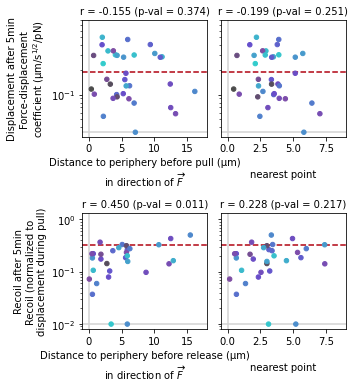

In [8]:
from scipy import stats

fig,ax=plt.subplots(2,2,sharey='row',figsize=(5,5.5),gridspec_kw={'width_ratios':[1,1]});

plt.sca(ax[0,0])
x=array([a[4][0] for a in ptsForFit_P[:-2]])
y=array([a[1]/(a[0]*(Delta_t_P*60)**.5) for a in ptsForFit_P[:-2]])
c=array([a[2] for a in ptsForFit_P[:-2]]).reshape(-1,4)
plt.title('r = %.3f (p-val = %.3f)'%stats.pearsonr(x,y), fontsize=10)
plt.scatter(x,y.clip(.035),c=c,s=20)
plt.axhline(G/(2*kT), c=colors['theory'], ls='--', zorder=0);
plt.yscale('log'); plt.ylim(.031,.8); plt.axhline(.035,c='lightgray',zorder=0);
plt.axvline(0,c='lightgray',zorder=0); #plt.axvline(1.5,c='lightgray',zorder=0)
plt.xlabel("Distance to periphery before pull (µm)\nin direction of $\overrightarrow{F}$");
plt.ylabel("Displacement after %smin\nForce-displacement\ncoefficient (µm/s$^{1/2}$/pN)"%str(Delta_t_P)); 
plt.xlim(-1,18);

plt.sca(ax[0,1])
x=array([a[4][1] for a in ptsForFit_P[:-2]])
y=array([a[1]/(a[0]*(Delta_t_P*60)**.5) for a in ptsForFit_P[:-2]])
c=array([a[2] for a in ptsForFit_P[:-2]]).reshape(-1,4)
plt.title('r = %.3f (p-val = %.3f)'%stats.pearsonr(x,y), fontsize=10)
plt.scatter(x,y.clip(.035),c=c,s=20)
plt.axhline(G/(2*kT), c=colors['theory'], ls='--', zorder=0);
plt.yscale('log'); plt.ylim(.031,.8); plt.axhline(.035,c='lightgray',zorder=0);
plt.axvline(0,c='lightgray',zorder=0); #plt.axvline(1.5,c='lightgray',zorder=0)
plt.xlabel("\nnearest point");
plt.xlim(-.5,9);

plt.sca(ax[1,0])
x=array([a[5][0] for a in ptsForFit_R[:-1]])
y=array([-a[1]/a[0] for a in ptsForFit_R[:-1]])
c=array([a[2] for a in ptsForFit_R[:-1]]).reshape(-1,4)
plt.title('r = %.3f (p-val = %.3f)'%stats.pearsonr(x,y), fontsize=10)
plt.scatter(x,y.clip(.01),c=c,s=20)
plt.axhline(((Delta_t_R/30)**.5-(1+Delta_t_R/30)**.5+1), c=colors['theory'], ls='--', zorder=0);
plt.yscale('log'); plt.ylim(.008,1.33); plt.axhline(.01,c='lightgray',zorder=0);
plt.axvline(0,c='lightgray',zorder=0); #plt.axvline(1.5,c='lightgray',zorder=0)
plt.xlabel("Distance to periphery before release (µm)\nin direction of $\overrightarrow{F}$");
plt.ylabel("Recoil after %smin\nRecoil (normalized to\ndisplacement during pull)"%str(Delta_t_R)); 
plt.xlim(-1,18);

plt.sca(ax[1,1])
x=array([a[5][1] for a in ptsForFit_R[:-1]])
y=array([-a[1]/a[0] for a in ptsForFit_R[:-1]])
c=array([a[2] for a in ptsForFit_R[:-1]]).reshape(-1,4)
plt.title('r = %.3f (p-val = %.3f)'%stats.pearsonr(x,y), fontsize=10)
plt.scatter(x,y.clip(.01),c=c,s=20)
plt.axhline(((Delta_t_R/30)**.5-(1+Delta_t_R/30)**.5+1), c=colors['theory'], ls='--', zorder=0);
plt.yscale('log'); plt.ylim(.008,1.33); plt.axhline(.01,c='lightgray',zorder=0);
plt.axvline(0,c='lightgray',zorder=0); #plt.axvline(1.5,c='lightgray',zorder=0)
plt.xlabel("\nnearest point");
plt.xlim(-.5,9);

plt.tight_layout()
plt.savefig('fig2_dist_periph.pdf')

print()


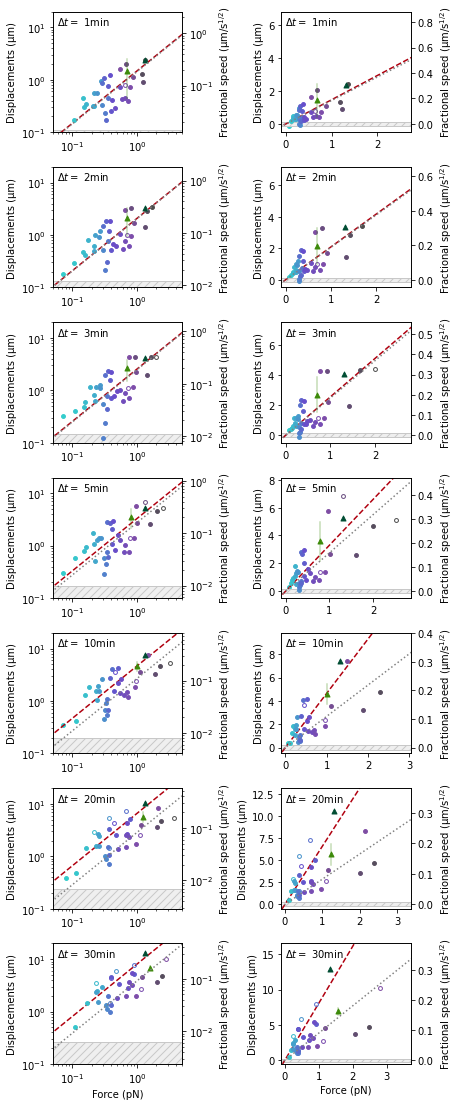

In [9]:
l_Delta_t_P=[1,2,3,5,10,20,30] # (min)

fig,ax=plt.subplots(len(l_Delta_t_P),2,sharex=False,figsize=[6.5,len(l_Delta_t_P)*2.2])

for j in range(len(l_Delta_t_P)):
    Delta_t_P=l_Delta_t_P[j]
    ptsForFit_P=[]

    ##------ 30min-pull/release data -------##
    for i,ds in enumerate(data_30min):
        if ds.t[-1]<Delta_t_P*60: continue
        displacement=interp1d(ds.t,ds.x[:,1],fill_value=nan)(Delta_t_P*60)
        col=cm_traj_30min(rankByInitForce[i])

        #force=ds.F[ds.indON,1] # Initial force
        # Average force over Delta_t_P
        ind_Delta_t_P=where(ds.t > Delta_t_P*60)[0][0]
        temp_t=r_[ds.t[ds.indON:ind_Delta_t_P],Delta_t_P*60]
        temp_F=interp1d(ds.t,ds.F[:,1],fill_value=nan)(temp_t)
        force=sum((temp_F[:-1]+temp_F[1:])/2*diff(temp_t))/(temp_t[-1]-temp_t[0])

        plt.sca(ax[j,0])
        plt.scatter(force, displacement, ec=c_[col], fc=(interp1d(ds.t_m,ds._data[:,-2].T)(Delta_t_P*60)> 1.5 )*c_[col], zorder=rankByInitForce[i], s=15)                
                
        interp1d(ds.t_m,ds._data[:,-2:].T)(Delta_t_P*60)
        plt.sca(ax[j,1])
        plt.scatter(force, displacement, ec=c_[col], fc=(interp1d(ds.t_m,ds._data[:,-2].T)(Delta_t_P*60)> 1.5 )*c_[col], zorder=rankByInitForce[i], s=15)
        ptsForFit_P.append([force, displacement, c_[col]])

    ##------ 100s-pull/release data -------##
    #---- From envelope of 100s PR trace
    displacement=envelope100s(Delta_t_P*60)[0]

    #force=-Fxyz[indPull[0],1]/2 # Initial force
    force=force100s_avgOverPRcycles(t[(t[indPull[0]]<=t)*(t<(t[indPull[0]]+Delta_t_P*60))]).mean() # Average force over Delta_t_P

    plt.sca(ax[j,0])
    plt.plot(   r_[1,1]*force, displacement,        c=   cm_traj_100s(.4), alpha=.3)
    plt.scatter(        force, displacement.mean(), c=c_[cm_traj_100s(.4)], s=25, marker='^')
    plt.sca(ax[j,1])
    plt.plot(   r_[1,1]*force, displacement,        c=   cm_traj_100s(.4), alpha=.3)
    plt.scatter(        force, displacement.mean(), c=c_[cm_traj_100s(.4)], s=25, marker='^')
    ptsForFit_P.append([force, displacement.mean(),   c_[cm_traj_100s(.4)]])

    # Extrapolation from last point of first pull of 100s PR trace, assuming 0.5 power law
    displacement=allPulls[0][-1,1]*(Delta_t_P*60/(t[allPulls[0].shape[0]]-dt))**.5
    force=Fxyz[indPull[0]:indRelease[0],1].mean()
    plt.sca(ax[j,0])
    plt.scatter(force, displacement, c=c_[cm_traj_100s(0)], s=25, marker='^')
    plt.sca(ax[j,1])
    plt.scatter(force, displacement, c=c_[cm_traj_100s(0)], s=25, marker='^')
    ptsForFit_P.append([force, displacement, c_[cm_traj_100s(0)]])

    # Diffusion background
    plt.sca(ax[j,0])
    plt.fill_between(r_[-.4,5],-(G*(Delta_t_P*60)**.5)**.5,(G*(Delta_t_P*60)**.5)**.5,edgecolor=colors['diffusion_hatch'],facecolor=colors['diffusion_fill'],hatch='///',zorder=0)
    plt.sca(ax[j,1])
    plt.fill_between(r_[-.4,5],-(G*(Delta_t_P*60)**.5)**.5,(G*(Delta_t_P*60)**.5)**.5,edgecolor=colors['diffusion_hatch'],facecolor=colors['diffusion_fill'],hatch='///',zorder=0)

    # Linear fit
    slopeFit_P,slopeFit_P_var=optimize.curve_fit((lambda f,slope: slope*f), [a[0] for a in ptsForFit_P], [a[1] for a in ptsForFit_P])
    G_F=slopeFit_P*2*kT/(Delta_t_P*60)**.5
    line=r_[-.2,5];
    plt.sca(ax[j,0])
    plt.plot(line,line*slopeFit_P,c='gray',ls=':')
    plt.sca(ax[j,1])
    plt.plot(line,line*slopeFit_P,c='gray',ls=':')
    #print("Slope pull: %.3f±%.3f µm/s^0.5/pN"%(slopeFit_P/(Delta_t_P*60)**.5,slopeFit_P_var**.5/(Delta_t_P*60)**.5))

    # Theoretical line, based on MSD prefactor.
    plt.sca(ax[j,0])
    plt.plot(line,line*G/(2*kT)*(Delta_t_P*60)**.5,c=colors['theory'],ls='--', zorder=0)
    plt.sca(ax[j,1])
    plt.plot(line,line*G/(2*kT)*(Delta_t_P*60)**.5,c=colors['theory'],ls='--', zorder=0)

    plt.sca(ax[j,0])
    plt.axvline(0,c='lightgray',zorder=0); plt.axhline(0,c='lightgray',zorder=0);
    plt.ylabel("Displacements (µm)");
    plt.text(.03,.97,"$\\Delta t =$ %smin"%str(Delta_t_P),transform=plt.gca().transAxes,va='top');
    plt.xscale('log'); plt.yscale('log'); plt.xlim(.05,5); plt.ylim(.1,20)
    ax1=plt.gca(); ax2=ax1.twinx(); ax2.set_yscale('log'); ax2.set_ylabel("Fractional speed (µm/s$^{1/2}$)"); ax2.set_ylim(*(r_[ax1.get_ylim()]/(Delta_t_P*60)**.5))
    plt.sca(ax[j,1])
    plt.ylabel("Displacements (µm)");
    plt.text(.03,.97,"$\\Delta t =$ %smin"%str(Delta_t_P),transform=plt.gca().transAxes,va='top');
    plt.xlim(-.1,3.7+(Delta_t_P-30)/30); plt.ylim(-0.5,16.5+(Delta_t_P-30)/3)
    ax1=plt.gca(); ax2=ax1.twinx(); ax2.set_yscale('linear'); ax2.set_ylabel("Fractional speed (µm/s$^{1/2})$"); ax2.set_ylim(*(r_[ax1.get_ylim()]/(Delta_t_P*60)**.5))

plt.sca(ax[-1,0]); plt.xlabel("Force (pN)");
plt.sca(ax[-1,1]); plt.xlabel("Force (pN)");

plt.tight_layout()
#plt.show()
plt.savefig('fig2_log_displ_scatter_allDt.pdf')



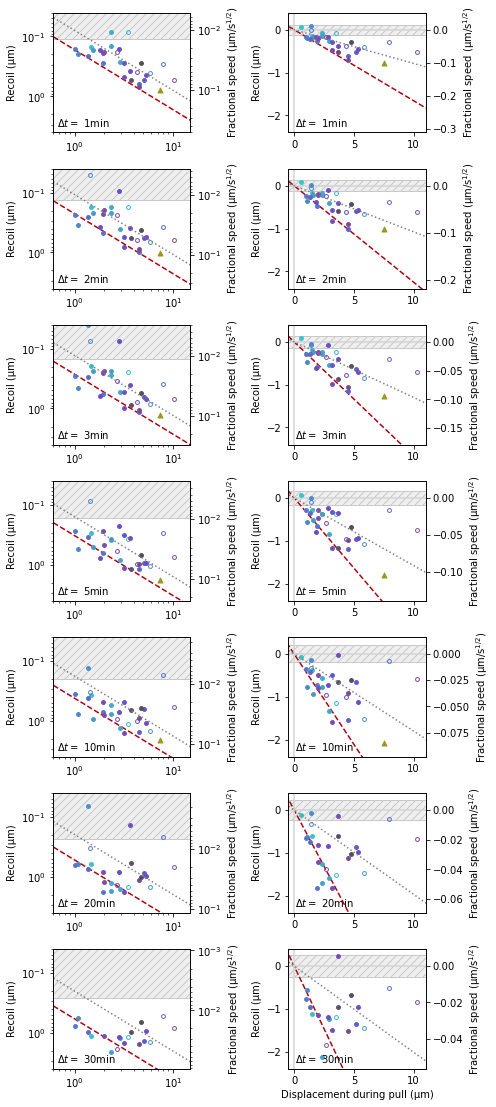

In [10]:
l_Delta_t_R=[1,2,3,5,10,20,30] # (min)

fig,ax=plt.subplots(len(l_Delta_t_R),2,sharex=False,figsize=[7,len(l_Delta_t_R)*2.2])

for j in range(len(l_Delta_t_R)):
    Delta_t_R=l_Delta_t_R[j]
    ptsForFit_R=[]

    ##------ 30min-pull/release data -------##
    for i,ds in enumerate(data_30min):
        if not hasattr(ds,'indOFF'): continue
        if ds.t[-1]<ds.tRelease+Delta_t_R*60: continue
        displacement=interp1d(ds.t,ds.x[:,1])(ds.tRelease+Delta_t_R*60)-ds.x[ds.indOFF,1]
        extensionBeforeRelease=ds.x[ds.indOFF,1]
        col=cm_traj_30min(rankByInitForce[i])
        plt.sca(ax[j,0])
        plt.scatter(extensionBeforeRelease, -displacement, ec=c_[col], fc=(ds._data[ds.indOFF_m-1][-2]> 1.5)*c_[col], zorder=rankByInitForce[i], s=15)
        plt.sca(ax[j,1])
        plt.scatter(extensionBeforeRelease, displacement, ec=c_[col], fc=(ds._data[ds.indOFF_m-1][-2]> 1.5)*c_[col], zorder=rankByInitForce[i], s=15)
        ptsForFit_R.append([extensionBeforeRelease, displacement])

    ##------ Last pull of 100s-pull/release data -------##
    if t[-1]-(t[indRelease[-1]]-dt)>=Delta_t_R*60:
        displacement=interp1d(t[:t.shape[0]-indRelease[-1]+1]-dt,pos[indRelease[-1]-1:,1]-pos[indRelease[-1]-1,1])(Delta_t_R*60)
        extensionBeforeRelease=pos[indRelease[-1]-1,1]
        plt.sca(ax[j,0])
        plt.scatter(extensionBeforeRelease, -displacement, c=c_[cm_traj_100s(1.)], s=25, marker='^')
        plt.sca(ax[j,1])
        plt.scatter(extensionBeforeRelease, displacement, c=c_[cm_traj_100s(1.)], s=25, marker='^')
        ptsForFit_R.append([extensionBeforeRelease, displacement])

    # Diffusion background
    plt.sca(ax[j,0])
    plt.fill_between(r_[-1,20],-(G*(Delta_t_R*60)**.5)**.5,(G*(Delta_t_R*60)**.5)**.5,edgecolor=colors['diffusion_hatch'],facecolor=colors['diffusion_fill'],hatch='///',zorder=0)
    plt.sca(ax[j,1])
    plt.fill_between(r_[-1,20],-(G*(Delta_t_R*60)**.5)**.5,(G*(Delta_t_R*60)**.5)**.5,edgecolor=colors['diffusion_hatch'],facecolor=colors['diffusion_fill'],hatch='///',zorder=0)

    # Linear fit
    slopeFit_R,slopeFit_R_var=optimize.curve_fit((lambda d,slope: slope*d), [a[0] for a in ptsForFit_R], [a[1] for a in ptsForFit_R])
    line=r_[-1,20];
    plt.sca(ax[j,0])
    plt.plot(line,-line*slopeFit_R,c='gray',ls=':')
    plt.sca(ax[j,1])
    plt.plot(line,line*slopeFit_R,c='gray',ls=':')

    # Theoretical line, based on MSD prefactor.
    plt.sca(ax[j,0])
    plt.plot(line,line*((Delta_t_R/30)**.5-(1+Delta_t_R/30)**.5+1),c=colors['theory'],ls='--', zorder=0)
    plt.sca(ax[j,1])
    plt.plot(line,-line*((Delta_t_R/30)**.5-(1+Delta_t_R/30)**.5+1),c=colors['theory'],ls='--', zorder=0)

    plt.sca(ax[j,0])
    plt.ylabel("Recoil (µm)")
    plt.text(.03,.03,"$\\Delta t =$ %smin"%str(Delta_t_R),transform=plt.gca().transAxes,va='bottom', ha='left');
    plt.xscale('log'); plt.yscale('log'); plt.xlim(.6,15); plt.ylim(4,.04)
    ax1=plt.gca(); ax2=ax1.twinx(); ax2.set_yscale('log'); ax2.set_ylabel("Fractional speed (µm/s$^{1/2}$)"); ax2.set_ylim(*(r_[ax1.get_ylim()]/(Delta_t_R*60)**.5))
    plt.sca(ax[j,1])
    plt.axvline(0,c='lightgray',zorder=0); plt.axhline(0,c='lightgray',zorder=0);
    plt.ylabel("Recoil (µm)")
    plt.text(.05,.03,"$\\Delta t =$ %smin"%str(Delta_t_R),transform=plt.gca().transAxes,va='bottom', ha='left');
    plt.xlim(-.5,11); plt.ylim(-2.4,0.4)
    ax1=plt.gca(); ax2=ax1.twinx(); ax2.set_yscale('linear'); ax2.set_ylabel("Fractional speed (µm/s$^{1/2}$)"); ax2.set_ylim(*(r_[ax1.get_ylim()]/(Delta_t_R*60)**.5))

plt.sca(ax[-1,0]); ax1.set_xlabel("Displacement during pull (µm)")
plt.sca(ax[-1,1]); ax1.set_xlabel("Displacement during pull (µm)")

plt.tight_layout()
#plt.show()
plt.savefig('fig2_log_recoil_scatter_allDt.pdf')
    

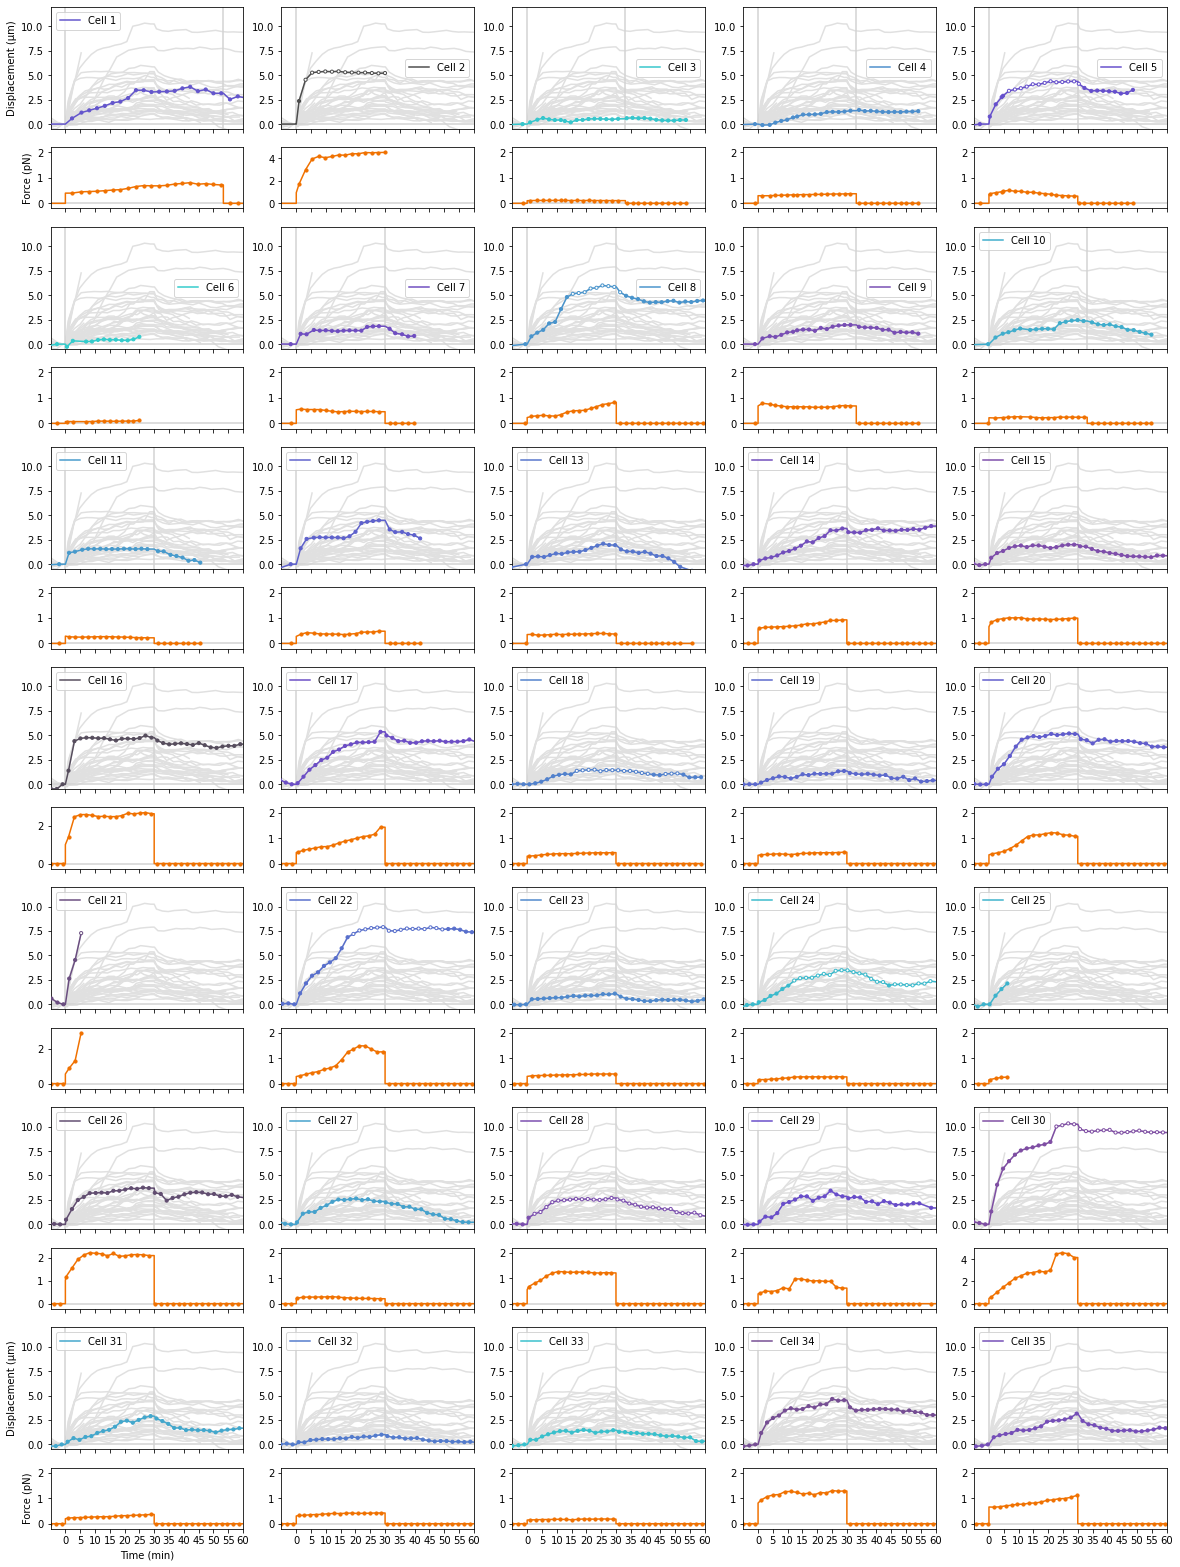

In [11]:
# Plot individual traces

nPlt_x=5; nPlt_y=int(ceil(len(data_30min)/nPlt_x))
fig,ax=plt.subplots(nPlt_y*2,nPlt_x,sharex=True,figsize=[4*nPlt_x,4*nPlt_y],gridspec_kw={'height_ratios':[4,2]*nPlt_y})

axFlat=ax.flatten()

for i,ds in enumerate(data_30min):

    plt.sca(axFlat[i%nPlt_x+int(i/nPlt_x)*2*nPlt_x])
    for ds2 in data_30min: plt.plot(ds2.t/60,ds2.x[:,1],c='#e0e0e0',zorder=0)
    col=cm_traj_30min(rankByInitForce[i])
    plt.plot(ds.t/60,ds.x[:,1],label="Cell %d"%(i+1), c=col, zorder=5) #label=ds.fname.split('/')[-1][:-4]
    plt.scatter(ds.t_m/60,ds.x_m[:,1],s=10, ec=c_[col], zorder=10, fc=array([[r_[1,1,1,1],col][a] for a in (ds._data[:,-2]> 1.5 )*1]))
    plt.axhline(0,c='lightgray',zorder=0)
    plt.axvline(0,c='lightgray',zorder=0)
    if hasattr(ds,'tRelease'): plt.axvline(ds.tRelease/60,c='lightgray',zorder=0)
    plt.xticks(r_[:100:5])
    plt.xlim(-5,60); plt.ylim(-0.5,12)
    plt.legend()

    plt.sca(axFlat[i%nPlt_x+int(i/nPlt_x)*2*nPlt_x+nPlt_x])
    plt.plot(ds.t/60,ds.F[:,1],c=colors['force'])
    plt.scatter(ds.t_m/60,ds.F_m[:,1],s=10,c=colors['force'])
    plt.axhline(0,c='lightgray',zorder=0)
    plt.ylim(*tuple(r_[-0.2,2.2]*max(ds.F[:,1].max(),2)/2))
    
    ax[0,0].set_ylabel('Displacement (µm)'); ax[-2,0].set_ylabel('Displacement (µm)');
    ax[1,0].set_ylabel('Force (pN)'); ax[-1,0].set_ylabel('Force (pN)');
    ax[-1,0].set_xlabel('Time (min)');
    

#plt.show()
plt.savefig('all_traces.pdf')


In [14]:
# Plot an individual trace

for i,ds in enumerate(data_30min):

    fig,ax=plt.subplots(3,1,sharex=True,figsize=[6,7],gridspec_kw={'height_ratios':[3,1,2]})

    plt.sca(ax[0])
    plt.title(ds.fname.split('/')[-1])
    plt.plot(ds.t/60,ds.x[:,1], c=cm_traj_30min(rankByInitForce[i]), label='y')
    plt.scatter(ds.t_m/60,ds.x_m[:,1], s=20, c=c_[cm_traj_30min(rankByInitForce[i])])
    plt.plot(ds.t/60,ds.x[:,0], c=cm_traj_30min(rankByInitForce[i]), alpha=.7, label='x')
    plt.plot(ds.t/60,ds.x[:,2], c=cm_traj_30min(rankByInitForce[i]), alpha=.3, label='z')
    plt.axhline(0,c='gray',zorder=0)
    plt.axvline(0,c='gray',zorder=0)
    plt.axvline(release_times_30min[i]/60,c='gray',zorder=0)
    plt.xlim(-5,60); plt.ylim(-0.5,12)
    plt.legend(loc='upper left'); plt.ylabel('Displacement (µm)'); plt.grid(c='lightgray')

    plt.sca(ax[1])
    plt.plot(ds.t/60,ds.F[:,1],c=colors['force'], label='$F_y$')
    plt.scatter(ds.t_m/60,ds.F_m[:,1], s=20, c=colors['force'])
    plt.plot(ds.t/60,ds.F[:,0],c=colors['force'], alpha=.7, label='$F_x$')
    plt.plot(ds.t/60,ds.F[:,2],c=colors['force'], alpha=.3, label='$F_z$')
    plt.axhline(0,c='gray',zorder=0)
    plt.ylim(*tuple(r_[-0.2,2.2]*max(ds.F[:,1].max(),2)/2))
    plt.legend(loc='upper right'); plt.ylabel('Force (pN)'); plt.grid(c='lightgray')

    plt.sca(ax[2])
    plt.scatter(ds._data[:,0]/60,ds._data[:,10], s=15, c="#404040", label='in direction of $\overrightarrow{F}$')
    plt.scatter(ds._data[:,0]/60,ds._data[:,11], s=15, c="#c0c0c0", label='nearest',zorder=0)
    plt.axhline(0,c='gray',zorder=0); plt.axhline(1.5,c='gray',zorder=0); plt.axhline(2,c='gray',zorder=0)
    plt.ylim(-1,10)
    plt.legend(loc='upper right'); plt.ylabel('Dist. to nucl. envelope (µm)'); plt.grid(c='lightgray')
    
    plt.xlabel('Time (min)')
    plt.tight_layout()
    #plt.show()
    plt.savefig('trajPlots/cell%02d_'%(i+1)+ds.fname.split('/')[-1][:-4]+'.png'); plt.close()

#print("range: %.3f-%.3f pN"%(ds.F[ds.F[:,1]!=0,1].min(), ds.F[:,1].max()))
#print("mean: %.3f pN"%(ds.F[ds.F[:,1]!=0,1].mean()))
#print("start: %.3f pN"%(ds.F[ds.indON,1]))
